# Machine Learning Pipeline for Fatigue Prediction in the full IBD Cohort

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
    roc_curve,
    roc_auc_score,
)
import shap

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    GroupShuffleSplit,
    GroupKFold,
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import AUROC
from torch.utils.data import Dataset, DataLoader

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = 1337  # Random seed to ensure reproducibility
output_path = "output/pytorch/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
file_prefix="pytorch"
# file_prefix = "biochem_remission"

## Data Loading

In [3]:
df = pd.read_csv("working_data/all_ibd_ml_input.csv")
# df = df[df["aggregate_disease_activity_Biochemical remission"] == 1] # Uncomment to run biochem remission pipeline

## Further Data Pre-Processing

In [4]:
# convert categorical columns to numerical
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fatigue_outcome"] = df["fatigue_outcome"].map({"fatigue": 1, "no_fatigue": 0})

In [5]:
# These columns are not features we want to use in the model
# Aggregate disease activity in some ways is a reflection of the other raw variables
columns_to_drop = [
    "aggregate_disease_activity_Active",
    "aggregate_disease_activity_Biochemical remission",
    "aggregate_disease_activity_Remission",
    "season_no_data",
    "study",
    "redcap_event_name_timepoint_1",
    "redcap_event_name_timepoint_2",
    "redcap_event_name_timepoint_3",
    "redcap_event_name_timepoint_4",
    "redcap_event_name_timepoint_5",
]

df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "baseline_eims_pyoderma_gangrenosum",
]

df.drop(columns=columns_to_drop, inplace=True)

## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [7]:
# Create Train Validate and Test Datasets

# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


In [8]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (768, 80)
Val shape: (186, 80)
Test shape: (261, 80)


In [9]:
numerical_features = [
    "age",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "ada_drug_level",
    "ifx_drug_level",
    "diagnosis_year",
    "disease_duration_weeks",
]
train_scaler = StandardScaler()  # We have tried a variety of scaling methods and they did not affect final model output
train_scaler.fit(X_train[numerical_features])
X_train[numerical_features] = train_scaler.transform(X_train[numerical_features])

test_scaler = StandardScaler()
test_scaler.fit(X_test[numerical_features])
X_test[numerical_features] = test_scaler.transform(X_test[numerical_features])

val_scaler = StandardScaler()
val_scaler.fit(X_val[numerical_features])
X_val[numerical_features] = val_scaler.transform(X_val[numerical_features])


## Deep Learning with PyTorch


In [10]:


class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 384)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(384, 352)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(352, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [11]:

def train_model(model, train_loader, epochs=10):
    # Equivalent to compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    auc_metric = AUROC(task="binary")  # For binary classification
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        auc_metric.reset()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            auc_metric.update(outputs, labels.long())

        epoch_loss = total_loss / len(train_loader)
        train_auc = auc_metric.compute().item()
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - AUC: {train_auc:.4f}")

        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
            val_labels = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
            val_outputs = model(val_inputs)
            val_auc_metric = AUROC(task="binary")
            val_auc_metric.update(val_outputs, val_labels.long())
            val_auc = val_auc_metric.compute().item()
            print(f"Validation AUC: {val_auc:.4f}")
        model.train()

        # Keep lists of AUC values across epochs
        if 'train_aucs' not in locals():
            train_aucs, val_aucs = [], []

        train_aucs.append(train_auc)
        val_aucs.append(val_auc)

        # Plot after the last epoch
        if epoch == epochs - 1:
            plt.plot(range(1, epochs + 1), train_aucs, label="Train AUC")
            plt.plot(range(1, epochs + 1), val_aucs, label="Validation AUC")
            plt.xlabel("Epoch")
            plt.ylabel("AUC")
            plt.legend()
            plt.show()

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset and DataLoader
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Epoch [1/20] - Loss: 0.6325 - AUC: 0.7258
Validation AUC: 0.7451
Epoch [2/20] - Loss: 0.5504 - AUC: 0.8098
Validation AUC: 0.7636
Epoch [3/20] - Loss: 0.5006 - AUC: 0.8450
Validation AUC: 0.7801
Epoch [4/20] - Loss: 0.4558 - AUC: 0.8695
Validation AUC: 0.8007
Epoch [5/20] - Loss: 0.4188 - AUC: 0.8936
Validation AUC: 0.8086
Epoch [6/20] - Loss: 0.3803 - AUC: 0.9132
Validation AUC: 0.8139
Epoch [7/20] - Loss: 0.3467 - AUC: 0.9290
Validation AUC: 0.8285
Epoch [8/20] - Loss: 0.2988 - AUC: 0.9470
Validation AUC: 0.8500
Epoch [9/20] - Loss: 0.2959 - AUC: 0.9469
Validation AUC: 0.8357
Epoch [10/20] - Loss: 0.2453 - AUC: 0.9651
Validation AUC: 0.8504
Epoch [11/20] - Loss: 0.2261 - AUC: 0.9708
Validation AUC: 0.8470
Epoch [12/20] - Loss: 0.1984 - AUC: 0.9776
Validation AUC: 0.8502
Epoch [13/20] - Loss: 0.1765 - AUC: 0.9818
Validation AUC: 0.8511
Epoch [14/20] - Loss: 0.1675 - AUC: 0.9846
Validation AUC: 0.8495
Epoch [15/20] - Loss: 0.1488 - AUC: 0.9868
Validation AUC: 0.8526
Epoch [16/20] - Los

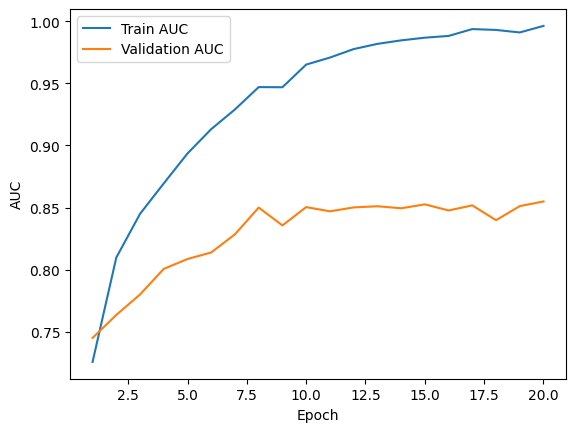

In [13]:
# Instantiate model and train
model = MyModel(input_dim=X_train.shape[1])
train_model(model, train_loader, epochs=20)

In [14]:
predictions = model(torch.tensor(X_test.to_numpy(), dtype=torch.float32)).detach().numpy().squeeze()

In [15]:
y_pred = model(torch.tensor(X_test.to_numpy(), dtype=torch.float32)).detach().numpy()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1,0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

Accuracy: 0.8084291187739464
Sensitivity: 0.8217821782178217
Specificity: 0.8
AUC: 0.8781559405940593


In [44]:
print("Number of false negatives (predicting no fatigue when there is fatigue):", fn)
print("Number of false positives (predicting fatigue when there is no fatigue):", fp)

Number of false negatives (predicting no fatigue when there is fatigue): 18
Number of false positives (predicting fatigue when there is no fatigue): 32


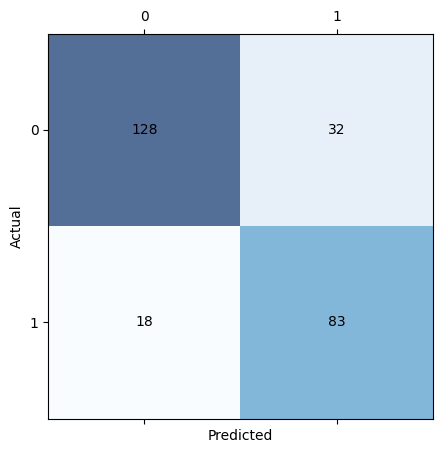

In [47]:
cm = confusion_matrix(y_test, y_classes)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

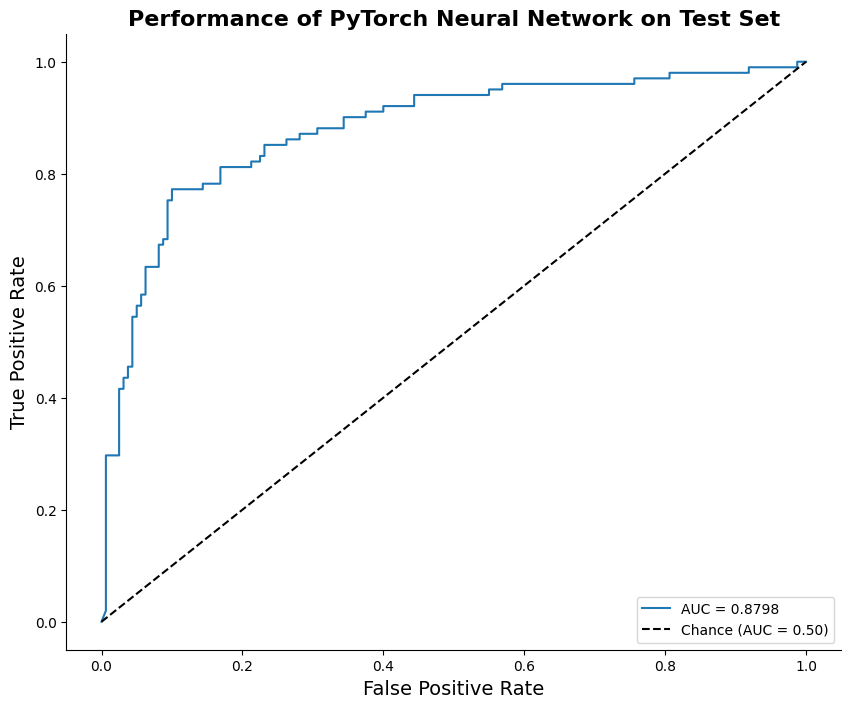

In [16]:
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(torch.tensor(X_test.to_numpy(), dtype=torch.float32))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr,
        label=f"AUC = {test_auc:.4f}",
    )

    # Add baseline and plot details
    plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Performance of PyTorch Neural Network on Test Set", fontsize=16, fontweight="bold")
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


    # Remove the top and right spines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Define the absolute path
    save_path = f"{output_path}{file_prefix}_roc_curves.png"

    # Save the plot to the specified path
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

## SHAP DeepExplainer

In [18]:
explainer = shap.DeepExplainer(model, torch.tensor(X_test.to_numpy(), dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(X_test.to_numpy(), dtype=torch.float32), check_additivity=False)

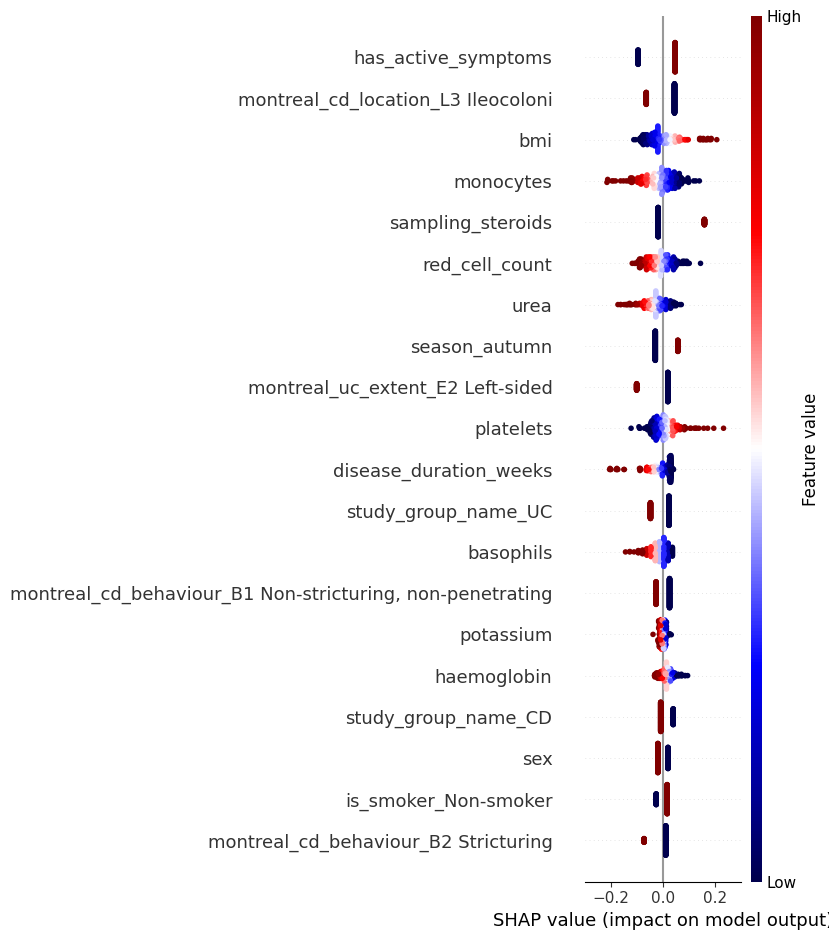

In [24]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.3, 0.3)
# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_pytorch_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

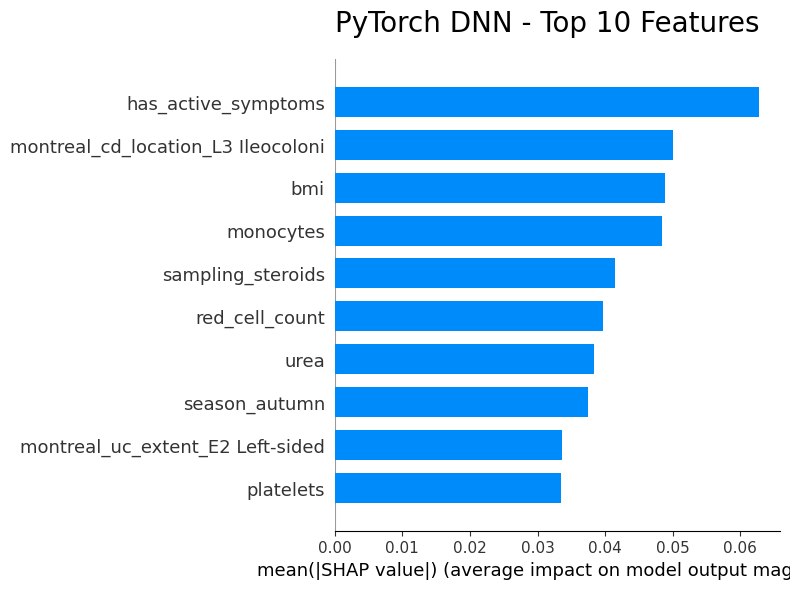

In [21]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=10,
)


plt.title("PyTorch DNN - Top 10 Features", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn_barplot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

## SHAP Kernel Explainer

In [30]:
with torch.no_grad():
    def predict(input_values):
        input_values = torch.tensor(input_values, dtype=torch.float32)
        return np.array(model(input_values))
    explainer = shap.KernelExplainer(model=predict, data=X_test.to_numpy())
    shap_values = explainer.shap_values(X_test.to_numpy())

Using 261 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 261/261 [05:27<00:00,  1.25s/it]


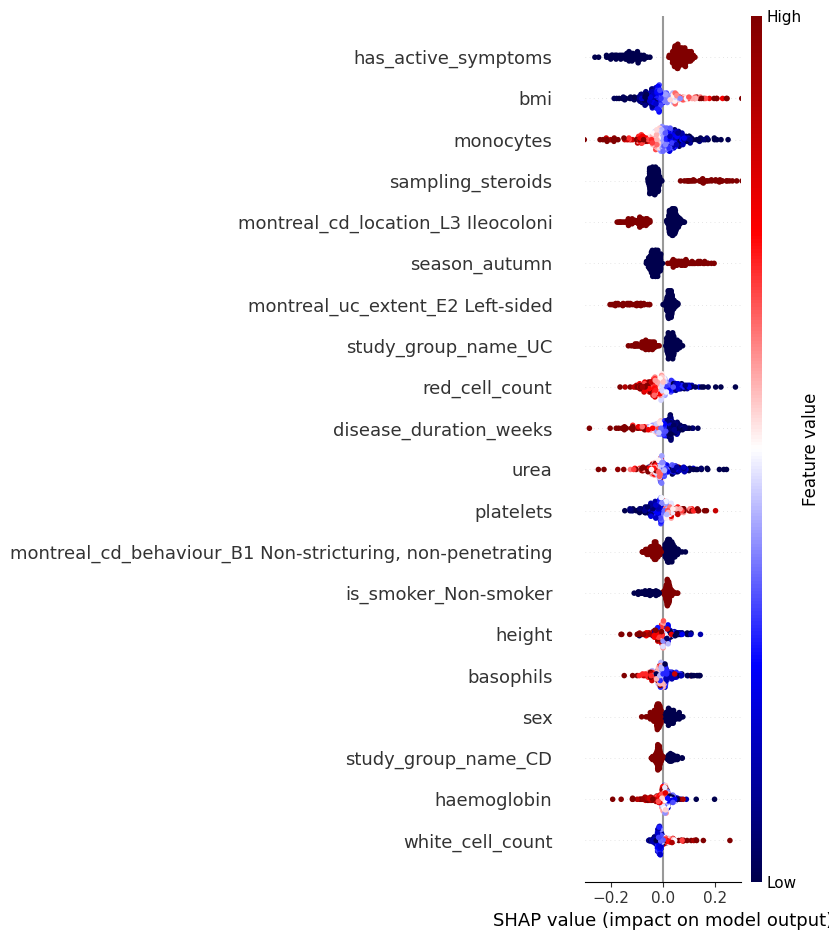

In [33]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.3, 0.3)
# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_pytorch_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

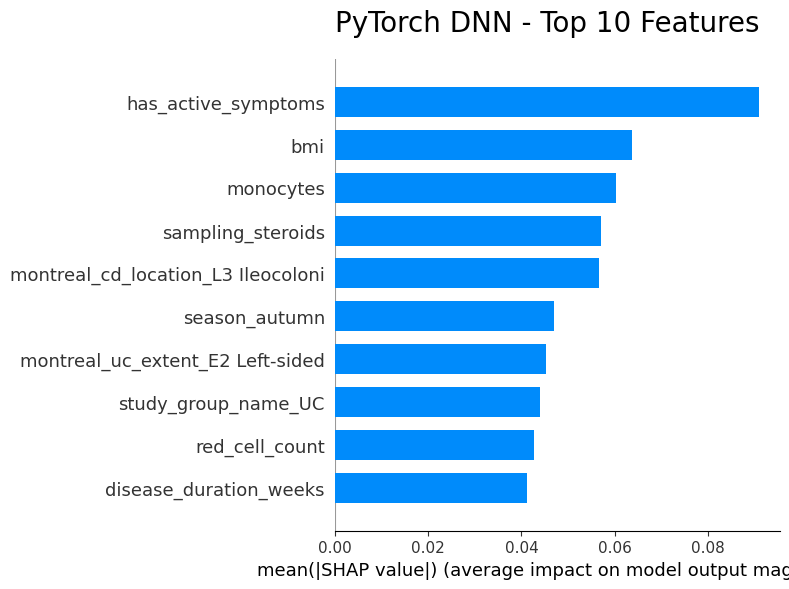

In [34]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=10,
)


plt.title("PyTorch DNN - Top 10 Features", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn_barplot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [35]:
shap.initjs()

In [36]:
X_test_reverted = X_test
X_test_reverted[numerical_features] = test_scaler.inverse_transform(X_test[numerical_features])
X_test_reverted[numerical_features] = X_test_reverted[numerical_features].round(2)

In [38]:
outcomes = pd.concat([y_test, pd.Series(y_classes.ravel(), index=y_test.index)], axis=1)
outcomes.columns = ["true", "predicted"]

incorrect_predictions = outcomes[outcomes["true"] != outcomes["predicted"]]
incorrect_predictions = incorrect_predictions.join(X_test_reverted)
incorrect_predictions.to_csv( f"{output_path}forceplots/incorrect_predictions/incorrect_predictions.csv", index=False)
shap_values_incorrect_predictions = pd.DataFrame(shap_values_class_1, index=y_test.index)
shap_values_incorrect_predictions = shap_values_incorrect_predictions.loc[incorrect_predictions.index]
shap_values_incorrect_predictions = shap_values_incorrect_predictions.to_numpy()
X_test_reverted_incorrect_predictions = X_test_reverted.loc[incorrect_predictions.index]
X_test_reverted_incorrect_predictions.reset_index(inplace=True)
X_test_reverted_incorrect_predictions.drop(columns=["index"], inplace=True)

In [39]:
for i in range(len(shap_values_incorrect_predictions)):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_incorrect_predictions[i],
        X_test_reverted_incorrect_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/incorrect_predictions/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


In [41]:
correct_predictions = outcomes[outcomes["true"] == outcomes["predicted"]]
correct_predictions = correct_predictions.join(X_test_reverted)
correct_predictions.to_csv(f"{output_path}forceplots/correct_predictions/correct_predictions.csv", index=False)
shap_values_correct_predictions = pd.DataFrame(shap_values_class_1, index=y_test.index)
shap_values_correct_predictions = shap_values_correct_predictions.loc[correct_predictions.index]
shap_values_correct_predictions = shap_values_correct_predictions.to_numpy()
X_test_reverted_correct_predictions = X_test_reverted.loc[correct_predictions.index]
X_test_reverted_correct_predictions.reset_index(drop=True, inplace=True)


In [42]:
for i in range(20): # plot only the first 20 correct predictions
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_correct_predictions[i],
        X_test_reverted_correct_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/correct_predictions/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")